In [29]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


from src.load_data import read_reviews, read_books, clean_reviews, clean_books

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.options.display.float_format = '{:,}'.format
# pd.set_option('display.max_colwidth', -1)

### Load reviews dataset

In [30]:
reviews_df = pd.read_csv('data/cleaned_reviews_mystery_1.csv')

In [31]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551765 entries, 0 to 1551764
Data columns (total 9 columns):
review_id      1551765 non-null object
user_id        1551765 non-null int64
book_id        1551765 non-null int64
rating         1551765 non-null int64
timestamp      1551765 non-null object
n_votes        1551765 non-null int64
n_comments     1551765 non-null int64
old_user_id    1551765 non-null object
old_book_id    1551765 non-null int64
dtypes: int64(6), object(3)
memory usage: 106.6+ MB


In [32]:
num_reviews = len(reviews_df)
num_reviews

1551765

In [53]:
num_book = reviews_df.book_id.nunique()
num_user = reviews_df.user_id.nunique()
num_book, num_user

(105365, 121333)

In [34]:
# reviews_df.book_id.value_counts()
reviews_df.user_id.value_counts()

119717    1846
57488     1699
103260    1354
77854     1279
88397     1243
          ... 
17895        1
12391        1
495          1
41077        1
30195        1
Name: user_id, Length: 121333, dtype: int64

In [35]:
reviews_df.head()

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
0,d23dc89ab32cd864e54d18369751163b,102489,37120,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084
1,c7613da4cbd48baa83efec99b4dd6a41,102489,96299,3,2001-01-11 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,79030
2,469b9d160ad68ce84b6cac4585fb226a,102489,82887,4,2001-01-25 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,442783
3,9f4fd2c20177f66fe5832ec299fb4bbf,102489,85615,2,2001-01-29 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,552719
4,0c7a29c98c4f11b409235d9c22a2455b,102489,50050,4,2001-02-02 00:00:00,1,0,d889b42d9eb7b80e02f24830e27c6389,238117


In [160]:
reviews_df['timestamp'].values

array(['2001-01-01 00:00:00', '2001-01-11 00:00:00',
       '2001-01-25 00:00:00', ..., '2017-11-03 18:42:32',
       '2017-11-03 21:12:55', '2017-11-03 22:17:08'], dtype=object)

In [36]:
user_dist = pd.DataFrame(reviews_df.user_id.value_counts()).reset_index()
user_dist.columns =['user_id', 'count']
user_dist.groupby('count').size()[:20]#.hist(bins=5)

count
1      5024
2     29481
3     17006
4     11165
5      8272
6      6176
7      4838
8      3870
9      3213
10     2792
11     2289
12     1961
13     1782
14     1508
15     1329
16     1139
17     1117
18      999
19      895
20      835
dtype: int64

In [45]:
user_dist['count_bins'] = pd.cut(x=user_dist['count'], bins=[1, 5, 10, 15, 20, 1846])

In [46]:
user_dist_count = user_dist.groupby('count_bins').count()

In [47]:
book_dist = pd.DataFrame(reviews_df.book_id.value_counts()).reset_index()
book_dist.columns =['book_id', 'count']
book_dist.groupby('count').size()#.hist(bins=5)

count
2        28412
3        16042
4        10358
5         7324
6         5527
         ...  
3997         1
4054         1
5698         1
7906         1
11373        1
Length: 608, dtype: int64

In [48]:
book_dist['count_bins'] = pd.cut(x=book_dist['count'], bins=[1, 5, 10, 15, 20, 11373])
book_dist_count = book_dist.groupby('count_bins').count()
book_dist_count
# book_dist_count.columns

,book_id,count
count_bins,,
"(1, 5]",62136,62136
"(5, 10]",18391,18391
"(10, 15]",7476,7476
"(15, 20]",4209,4209
"(20, 11373]",13153,13153


In [49]:
user_book_count = pd.DataFrame({'num_users':user_dist_count['count'].values, 'num_books':book_dist_count['count'].values})
user_book_count

,num_users,num_books
0,65924,62136
1,20889,18391
2,8869,7476
3,4985,4209
4,15642,13153


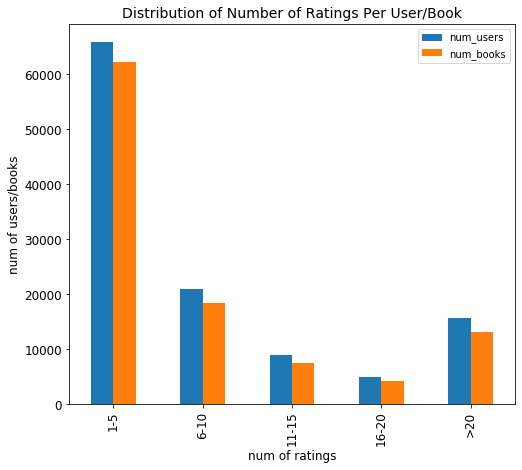

In [50]:
user_book_count['count_bins'] = ['1-5', '6-10', '11-15', '16-20', '>20']
user_book_count.plot(kind='bar', x='count_bins', y= ['num_users', 'num_books'], fontsize = 12, figsize=(8,7))
plt.title('Distribution of Number of Ratings Per User/Book', fontsize = 14)
plt.xlabel('num of ratings', fontsize = 12)
plt.legend()
plt.ylabel('num of users/books',fontsize = 12)
plt.savefig('visualization/clean_dist_of_num_ratings.png')


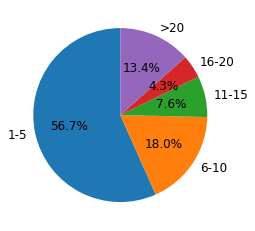

In [59]:
fig = plt.gcf()
fig.set_size_inches(4,4)
plt.pie(user_book_count.num_users, labels=user_book_count.count_bins, startangle=90, autopct='%.1f%%', textprops={'fontsize': 12})
# plt.title('Distribution of Num_of_Ratings Per User', fontsize = 14)
plt.savefig('visualization/clean_pie_of_num_ratings_users.png');

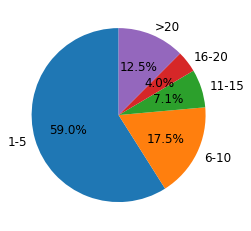

In [60]:
fig = plt.gcf()
fig.set_size_inches(4,4)
plt.pie(user_book_count.num_books, labels=user_book_count.count_bins, startangle=90, autopct='%.1f%%', textprops={'fontsize': 12})
# plt.title('Distribution of Num_of_Ratings Per Book', fontsize = 14)
plt.savefig('visualization/clean_pie_of_num_ratings_books.png');

### rating distribution

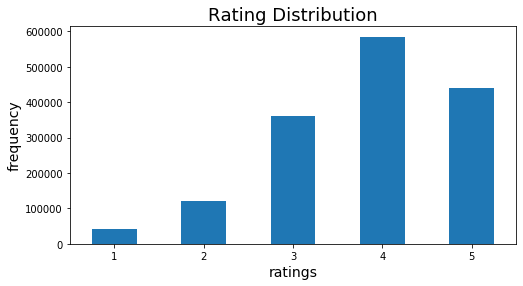

In [81]:
# rating distribution
reviews_df.groupby('rating').size().plot(kind='bar', figsize=(8,4))
plt.title('Rating Distribution', fontsize=18)
plt.xlabel('ratings', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.xticks(rotation='horizontal')
plt.savefig('visualization/clean_genre_crime_rating_dist.png');

### n_votes

In [66]:
pct = reviews_df[reviews_df.n_votes > 0].groupby('n_votes').size().sum()/len(reviews_df[reviews_df.n_votes >= 0])
print('%.3f of reviews received votes'%pct)

0.256 of reviews received votes


In [67]:
print('the max number of votes a review received is %d'%reviews_df.n_votes.max())

the max number of votes a review received is 904


In [ ]:
# reviews_df1[reviews_df1.n_votes == reviews_df1.n_votes.max()].review_text

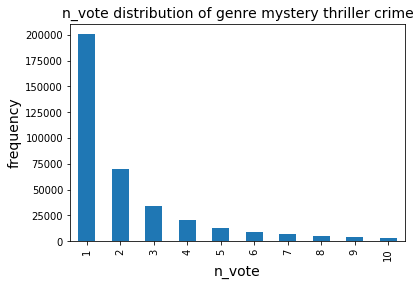

In [69]:
len(reviews_df.n_votes.unique())
len(reviews_df[reviews_df.n_votes >= 0])
reviews_df[reviews_df.n_votes >= 0].groupby('n_votes').size()[1:11].plot(kind='bar')
plt.title('n_vote distribution of genre mystery thriller crime', fontsize=14)
plt.xlabel('n_vote', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.savefig('visualization/genre_crime_n_vote_dist.png');

### n_comments

In [70]:
pct = reviews_df[reviews_df.n_comments > 0].groupby('n_votes').size().sum()/len(reviews_df[reviews_df.n_comments >= 0])
print('%.3f of reviews received comments'%pct)

0.076 of reviews received comments


In [71]:
print('the max number of votes a review received is %d'%reviews_df.n_comments.max())

the max number of votes a review received is 348


In [ ]:
# reviews_df1[reviews_df1.n_comments == reviews_df1.n_comments.max()].review_text

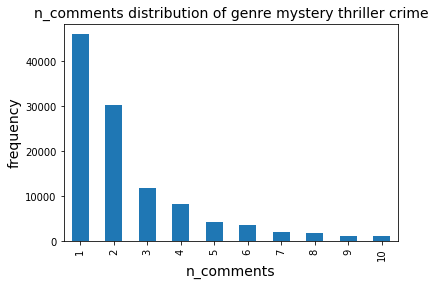

In [72]:
reviews_df[reviews_df.n_comments >= 0].groupby('n_comments').size()[1:11].plot(kind='bar')
plt.title('n_comments distribution of genre mystery thriller crime', fontsize=14)
plt.xlabel('n_comments', fontsize=14)
plt.ylabel('frequency', fontsize=14)
# plt.ylim(0, 200000)
plt.savefig('genre_crime_n_comments_dist.png');

### Load books dataset

In [74]:
books_df = pd.read_csv('data/cleaned_books_mystery_1.csv')

In [75]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105365 entries, 0 to 105364
Data columns (total 12 columns):
book_id               105365 non-null int64
title                 105365 non-null object
num_pages             105365 non-null int64
is_ebook              105365 non-null int64
link                  105365 non-null object
average_rating        105365 non-null float64
ratings_count         105365 non-null int64
text_reviews_count    105365 non-null int64
author_id             105365 non-null int64
publisher             76004 non-null object
similar_books         105365 non-null object
old_book_id           105365 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 9.6+ MB


In [76]:
num_books = len(books_df)
num_books

105365

In [77]:
books_df1 = books_df.copy()

### concat genre

In [87]:
books_df.title
for i in books_df.title:
    print(i)
    break

The House of Memory (Pluto's Snitch #2)


In [100]:
books_for_title = books_df.sample(n=int(round(len(books_df)*0.1,0)))

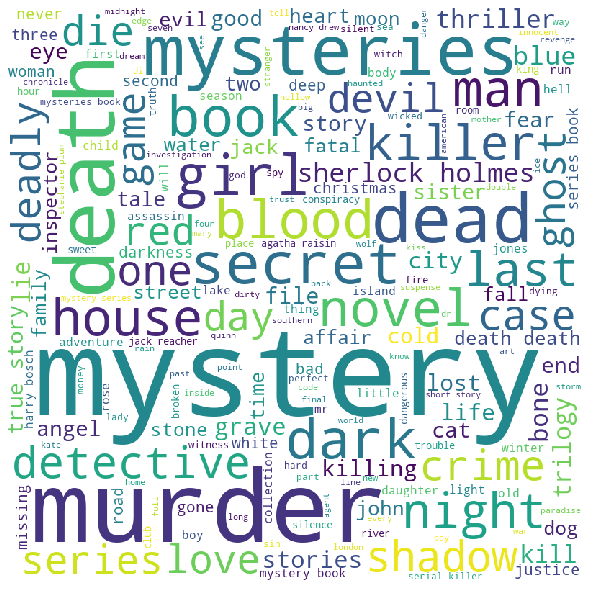

In [101]:
from wordcloud import WordCloud, STOPWORDS 

comment_words = ' '
stopwords = set(STOPWORDS)  
# iterate through the csv file 
for val in books_for_title.title: 
    
    # split the value 
    tokens = val.split()    
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()           
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('visualization/word_cloud_for_title.png')
  
plt.show()

### extract the first author id

In [102]:
books_df.author_id.nunique()

22620

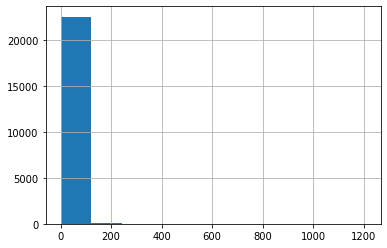

In [120]:
books_df.groupby('author_id').size().hist(bins=10)

In [121]:
books_df.author_id.value_counts()

123715     1207
3780        999
3389        505
17065       487
2448        443
           ... 
7827259       1
6579681       1
6446566       1
253741        1
1142747       1
Name: author_id, Length: 22620, dtype: int64

In [137]:
author_dist = pd.DataFrame(books_df.author_id.value_counts()).reset_index()
author_dist.columns =['author_id', 'book_counts']
author_dist.groupby('book_counts').size()
author_dist

,author_id,book_counts
0,123715,1207
1,3780,999
2,3389,505
3,17065,487
4,2448,443
...,...,...
22615,7827259,1
22616,6579681,1
22617,6446566,1
22618,253741,1


In [127]:
(author_dist['book_counts'] ==1).sum()/len(author_dist)

0.48691423519009724

In [129]:
author_dist['book_counts_bins'] = pd.cut(x=author_dist['book_counts'], bins=[0, 1, 5, 10, 15, 20, 1207])
author_dist_count = author_dist.groupby('book_counts_bins').count()
author_dist_count

,author_id,book_counts
book_counts_bins,,
"(0, 1]",11014,11014
"(1, 5]",8017,8017
"(5, 10]",1806,1806
"(10, 15]",680,680
"(15, 20]",346,346
"(20, 1207]",757,757


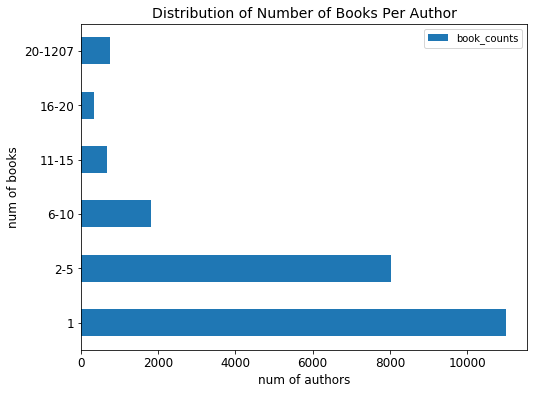

In [149]:
author_dist_count['count_bins'] = ['1','2-5', '6-10', '11-15', '16-20', '20-1207']
author_dist_count.plot(kind='barh', x='count_bins', y= 'book_counts', fontsize = 12, figsize=(8,6))
plt.title('Distribution of Number of Books Per Author', fontsize = 14)
plt.xlabel('num of authors', fontsize = 12)
plt.ylabel('num of books',fontsize = 12)
plt.savefig('visualization/clean_dist_of_book_cross_author.png')


In [141]:
# ax = sns.countplot(y="book_counts", data=author_dist)
# plt.title('Distribution of  Configurations')
# plt.xlabel('Number of Axles')

# total = len(author_dist['book_counts'])
# for p in ax.patches:
#         percentage = '{:.1f}%'.format(100 * p.get_width()/total)
#         x = p.get_x() + p.get_width() + 0.02
#         y = p.get_y() + p.get_height()/2
#         ax.annotate(percentage, (x, y))

In [154]:
publisher_dist = pd.DataFrame(books_df.publisher.value_counts()).reset_index()
publisher_dist.columns =['publisher', 'book_counts']
publisher_dist.groupby('book_counts').size()
publisher_dist['book_counts_bins'] = pd.cut(x=author_dist['book_counts'], bins=[0, 1, 5, 10, 15, 20, 6532])
publisher_dist_count = publisher_dist.groupby('book_counts_bins').count()
publisher_dist_count

,publisher,book_counts
book_counts_bins,,
"(0, 1]",0,0
"(1, 5]",7010,7010
"(5, 10]",1806,1806
"(10, 15]",680,680
"(15, 20]",346,346
"(20, 6532]",757,757


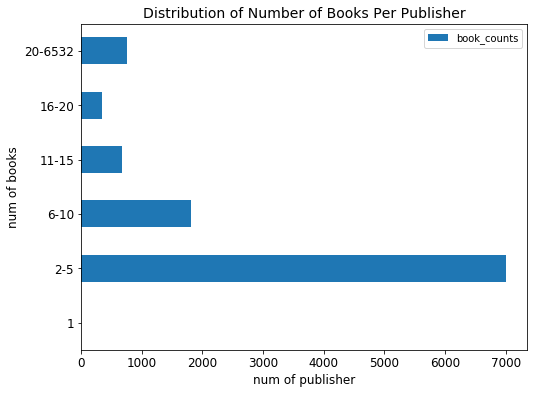

In [156]:
publisher_dist_count['count_bins'] = ['1','2-5', '6-10', '11-15', '16-20', '20-6532']
publisher_dist_count.plot(kind='barh', x='count_bins', y= 'book_counts', fontsize = 12, figsize=(8,6))
plt.title('Distribution of Number of Books Per Publisher', fontsize = 14)
plt.xlabel('num of publisher', fontsize = 12)
plt.ylabel('num of books',fontsize = 12)
plt.savefig('visualization/clean_dist_of_book_cross_publisher.png')

In [144]:
len(books_df.publisher.unique())

10600

In [110]:
books_df.publisher.value_counts()

Berkley                             1843
Minotaur Books                      1558
Bantam                              1017
Grand Central Publishing             891
Ballantine Books                     771
                                    ... 
Ylva Verlag E.Kfr.                     1
Lynda McDaniel Books                   1
VB Publishing                          1
Cappelen                               1
Matador/Troubador Publishing Ltd       1
Name: publisher, Length: 10599, dtype: int64

In [ ]:
# convert average_rating, ratings_count, text_reviews_count to float/integer
books_df1.average_rating =books_df1.average_rating.astype('float')
books_df1.ratings_count =books_df1.ratings_count.astype('int')
books_df1.text_reviews_count =books_df1.text_reviews_count.astype('int')

In [161]:
# In order to convert num_pages to integer, we replace nan with zero. 
# With the data type of integer, we can replace zero with mean.
books_df.num_pages = books_df.num_pages.fillna(0)
books_df1.num_pages =books_df.num_pages.astype('int')
mean = round(books_df.num_pages[books_df.num_pages != 0].mean())
books_df.num_pages = books_df.num_pages.replace(0, mean)

In [162]:
books_df.head()

,book_id,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books,old_book_id
0,75512,The House of Memory (Pluto's Snitch #2),318,1,https://www.goodreads.com/book/show/33394837-t...,4.33,269,60,242185,NaN,[],33394837
1,35550,"Dead in the Morning (Patrick Grant, #1)",312,0,https://www.goodreads.com/book/show/1902202.De...,3.3,52,8,190988,Ulverscroft,[],1902202
2,62948,Wycliffe and the Cycle of Death,320,0,https://www.goodreads.com/book/show/2805495-wy...,3.61,58,8,1533165,Orion,[],2805495
3,25973,"White Fire (Pendergast, #13)",13,0,https://www.goodreads.com/book/show/17368265-w...,4.07,250,46,12577,Grand Central Publishing,"['11007668', '16065538', '15841850', '13539179...",17368265
4,95727,"Polar Star (Arkady Renko, #2)",366,0,https://www.goodreads.com/book/show/778285.Pol...,3.99,5376,224,8258,Ballantine Books,"['312134', '12160902', '8518058', '209199', '1...",778285


In [163]:
books_df.describe()

,book_id,num_pages,is_ebook,average_rating,ratings_count,text_reviews_count,author_id,old_book_id
count,"105,365.0","105,365.0","105,365.0","105,365.0","105,365.0","105,365.0","105,365.0","105,365.0"
mean,"52,682.0",311.9063730840412,0.3314668058653253,3.8587802401176976,"1,029.0108954586437",70.79663075973995,"2,627,644.678574479","14,543,184.251876809"
std,"30,416.399893807287",112.18458871929242,0.47074267453407576,0.32113875771842754,"13,124.042199241883",532.0395935786072,"3,857,843.376945385","10,850,398.273148153"
min,0.0,1.0,0.0,1.45,2.0,1.0,14.0,164.0
25%,"26,341.0",273.0,0.0,3.67,33.0,8.0,"35,691.0","3,106,651.0"
50%,"52,682.0",312.0,0.0,3.87,97.0,16.0,"332,472.0","13,616,767.0"
75%,"79,023.0",349.0,1.0,4.06,333.0,39.0,"4,763,995.0","23,492,767.0"
max,"105,364.0","2,837.0",1.0,5.0,"2,046,499.0","78,438.0","17,330,593.0","36,463,859.0"


#### Explore country and language code

These books are 100% US country code.

There are 85 languages. Except for the 37.6% missing values, 45% of books are in English, 10% are in Italy, Germany, Spanish, Dutch, French and Portuguese. (93% in total)

#### num_pages, is_ebook, rating counts and text review counts

In [168]:
len(books_df.num_pages.unique())

962

/Users/elainewu/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


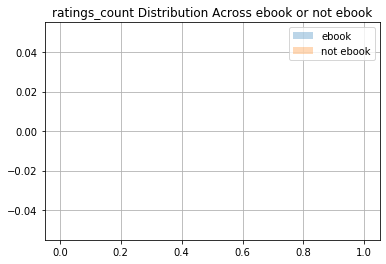

In [169]:
#Rating Distribution Across ebook or not ebook
books_df[books_df.is_ebook == 'true'].average_rating.hist(bins=10,label='ebook', alpha =0.3)
books_df[books_df.is_ebook == 'false'].average_rating.hist(bins=10, label='not ebook', alpha =0.3)
plt.legend()
plt.title('ratings_count Distribution Across ebook or not ebook');

### Merge reviews and book graph

In [166]:
book_review = pd.merge(reviews_df, books_df, on=['book_id'])

In [170]:
len(book_review)

1551765

In [171]:
book_review.columns

Index(['review_id', 'user_id', 'book_id', 'rating', 'timestamp', 'n_votes',
       'n_comments', 'old_user_id', 'old_book_id_x', 'title', 'num_pages',
       'is_ebook', 'link', 'average_rating', 'ratings_count',
       'text_reviews_count', 'author_id', 'publisher', 'similar_books',
       'old_book_id_y'],
      dtype='object')

In [172]:
book_review.head()

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id_x,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books,old_book_id_y
0,d23dc89ab32cd864e54d18369751163b,102489,37120,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084,Night Walker (Hard Case Crime #16),312,0,https://www.goodreads.com/book/show/196084.Nig...,3.41,228,28,114241,NaN,"['812419', '552746', '552743', '552745', '8448...",196084
1,03c45d1bd2b0c51f72f0b076009a7d2e,103659,37120,3,2008-08-22 07:47:28,7,0,daf981a1d26ecf0f66c5e13260ea921e,196084,Night Walker (Hard Case Crime #16),312,0,https://www.goodreads.com/book/show/196084.Nig...,3.41,228,28,114241,NaN,"['812419', '552746', '552743', '552745', '8448...",196084
2,430f3fa3caca2cef77ea3e6647c1012a,118306,37120,3,2009-09-20 00:32:19,0,0,f9a22b44dbc2aa86c77dc876c965ddc8,196084,Night Walker (Hard Case Crime #16),312,0,https://www.goodreads.com/book/show/196084.Nig...,3.41,228,28,114241,NaN,"['812419', '552746', '552743', '552745', '8448...",196084
3,f9699ea0db151a815ff19d8cbecd4a8e,23622,37120,3,2010-08-08 10:14:26,14,2,31c85fc6bf4ed80533c3212fc88b8386,196084,Night Walker (Hard Case Crime #16),312,0,https://www.goodreads.com/book/show/196084.Nig...,3.41,228,28,114241,NaN,"['812419', '552746', '552743', '552745', '8448...",196084
4,12aa49e83ab5426c1427fe13f03a6fb0,68304,37120,3,2012-09-30 06:42:30,1,0,8ffb94b5b5c0612b1013c10adb5d68a6,196084,Night Walker (Hard Case Crime #16),312,0,https://www.goodreads.com/book/show/196084.Nig...,3.41,228,28,114241,NaN,"['812419', '552746', '552743', '552745', '8448...",196084


### plot different genre rating distribution

In [ ]:
def mask(df, key, function):
    return df[function(df[key])]

    """
    Returns a filtered dataframe, by applying function to key
    """

def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

def filtered_hist(field, label, filter):
    """
    Creates a layered chart of histograms.
    The first layer (light gray) contains the histogram of the full data, and the
    second contains the histogram of the filtered data.
    Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
    """
    base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
      ).properties(
      width=300,
      )
    return alt.layer(base.transform_filter(filter),
                       base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),).resolve_scale(y='independent')

In [ ]:
import altair as alt
books_ratings = books_df1.merge(reviews_df1
                               .groupby('book_id', as_index=False)
                                .agg({'rating': ['count', 'mean']})
                                .flatten_cols(),
                                on='book_id')

language_filter = alt.selection_multi(fields=['language_code'])
language_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('language_code'),
    color=alt.condition(
        language_filter,
        alt.Color("language:N"),
        alt.value('lightgray'))
).properties(height=300, selection=language_filter)

In [ ]:
alt.hconcat(
    filtered_hist('rating count', '# ratings / book', language_filter),
    filtered_hist('rating mean', 'mean book rating', language_filter),
    language_chart,
    data=books_ratings)